In [90]:
using DataFrames #for data wrangling
using StatsPlots #for plotting
using Turing #for MCMC
using CSV #CSV import
using Random #data generation (if required)
using Distributions

Import Data

In [91]:
#this is a local document, but i've also saved a slightly cleaned up version in github with the same "valveTestRaw" title
valveData = CSV.read("./Results of New Valve Tests.csv", DataFrame)

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,b,13,0,0,0.00%,0.00%,missing,air
3,c,85,1,1,13.00%,9.70%,175,steam
4,d,108,21,4,4.50%,1.50%,350,air
5,e,1,0,0,0.00%,0.00%,missing,na
6,f,55,9,2,5.50%,2.50%,400,liquid
7,g,41,5,2,6.70%,3.30%,165,steam
8,h,2,0,0,0.00%,0.00%,missing,air
9,z,40,6,1,24.00%,20.00%,165,steam


Collect Number of Trials & Separate into Service Mediums

In [92]:
# vendors = (collect(valveData[:,1]))
# n=0
# for i in 1:length(vendors)
#     n = valveData[i, 2] + n
# end
# n

steamDF = []
airDF = []
liquidDF = []
airLiqDF = []

steamDF = filter(:Service => ==("steam"), valveData)
airDF = filter(:Service => ==("air"), valveData)
liquidDF = filter(:Service => ==("liquid"), valveData)
airLiqDF = filter(:Service => ==("air/liquid"), valveData)
naDF = filter(:Service => ==("na"), valveData)

n_steam = 0
n_air = 0
n_liquid = 0
n_airLiq = 0
n_na = 0

steamVend = (collect(steamDF[:,1]))
for i in 1:length(steamVend)
    n_steam = steamDF[i,2] +n_steam
end

airVend = (collect(airDF[:,1]))
for i in 1:length(airVend)
    n_air = airDF[i,2] +n_air
end

liquidVend = (collect(liquidDF[:,1]))
for i in 1:length(liquidVend)
    n_liquid = liquidDF[i,2] +n_liquid
end

airLiqVend = (collect(airLiqDF[:,1]))
for i in 1:length(airLiqVend)
    n_airLiq = airLiqDF[i,2] +n_airLiq
end

naVend = (collect(naDF[:,1]))
for i in 1:length(naVend)
    n_na = naDF[i,2]+n_na
end

steamDF

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,c,85,1,1,13.00%,9.70%,175,steam
3,g,41,5,2,6.70%,3.30%,165,steam
4,z,40,6,1,24.00%,20.00%,165,steam
5,k,1,0,0,0.00%,0.00%,missing,steam
6,m,14,7,3,10.00%,3.00%,80,steam


Set Up Model

In [93]:
@model function valveTesting(Vendors, Population, highPops) # rejects serviceMedium)
    #additional functionality can be added to this, especially when considering that the probability of failing (p-1) is the sum of the probability of failing on a low pop (less dangerous) & a high pop (more dangerous)      
    
    
    #hyper prior
        μ ~ Beta(4, 2)
        σ ~ Exponential(1)
    
        p = Vector{Real}(undef, length(Vendors))
        n = Vector{Real}(undef, length(Vendors))
        valvePass = Vector{Real}(undef, length(Vendors))
    for i in 1:length(Vendors)
        
        #prior
        #n[i] = Population[1, i]
        #p[i] ~ Normal(μ, 1)
        #distribution of valves passing given pass probability p and n trials
        #valvePass[i] ~ Binomial(n[i], p[i])
        valvePass[i] ~ Normal(μ, σ)
    end
end

valveTesting (generic function with 2 methods)

In [94]:
steam_model = valveTesting(steamDF[:,1], steamDF[:,2], steamDF[:,3])

steam_posterior = sample(steam_model, NUTS(), 1000)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\flemm\.julia\packages\Turing\oFGEb\src\mcmc\hmc.jl:213
Sampling   0%|█                                         |  ETA: 0:03:41
Sampling   1%|█                                         |  ETA: 0:01:50
Sampling   1%|█                                         |  ETA: 0:01:15
Sampling   2%|█                                         |  ETA: 0:00:56
Sampling   2%|█                                         |  ETA: 0:00:45
Sampling   3%|██                                        |  ETA: 0:00:37
Sampling   3%|██                                        |  ETA: 0:00:32
Sampling   4%|██                                        |  ETA: 0:00:28
Sampling   4%|██                                        |  ETA: 0:00:25
Sampling   5%|██                                        |  ETA: 0:00:23
Sampling   5%|███                                       |  ETA: 0:00:20
Sampling   

Chains MCMC chain (1000×20×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.97 seconds
Compute duration  = 2.97 seconds
parameters        = μ, σ, valvePass[1], valvePass[2], valvePass[3], valvePass[4], valvePass[5], valvePass[6]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std      mcse    ess_bulk   ess_tail      rhat  ⋯
        Symbol   Float64   Float64   Float64     Float64    Float64   Float64  ⋯

             μ    0.6633    0.1907    0.0090    403.1132   553.5123    1.0000  ⋯
             σ    1.3605    0.9962    0.1254     37.8708    37.7154    1.0399  ⋯
  valvePass[1]    0.6535    1.6871    0.0490   1093.7050   402.2301    1.0175  ⋯
  valvePass[2]    0.6652    1.7331    0.0563   1112.4401   341.2340

In [95]:
postDF = DataFrame(steam_posterior)



Row,iteration,chain,μ,σ,valvePass[1],valvePass[2],valvePass[3],valvePass[4],valvePass[5],valvePass[6],lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,501,1,0.894037,0.93889,2.05429,1.43509,-0.429931,1.17715,1.78865,1.15661,-10.5413,7.0,1.0,0.994318,-10.5413,14.183,-0.0195684,-0.480651,3.0,0.0,0.299158,0.299158
2,502,1,0.839738,0.762903,1.31698,-0.00479714,0.0898588,0.560237,1.86426,2.07932,-9.86856,7.0,1.0,0.988693,-9.86856,13.0397,0.0101903,-0.12754,3.0,0.0,0.299158,0.299158
3,503,1,0.715546,2.05606,-0.0846105,1.7583,1.83346,0.960728,-0.691519,-1.07294,-13.0029,7.0,1.0,0.609579,-13.0029,15.3407,0.535589,1.20968,3.0,0.0,0.299158,0.299158
4,504,1,0.675316,1.94604,0.711031,2.2476,-1.3184,-1.11803,-0.865783,0.13128,-13.2416,7.0,1.0,0.810107,-13.2416,18.0556,-0.102354,1.44067,2.0,0.0,0.299158,0.299158
5,505,1,0.613744,0.815047,0.186559,0.274844,0.764295,2.10455,-0.859317,-0.437283,-10.544,7.0,1.0,0.913862,-10.544,15.4216,-0.553835,0.864565,3.0,0.0,0.299158,0.299158
6,506,1,0.362067,1.00516,0.542922,0.659683,-0.209993,-0.845947,0.67611,-0.0388456,-9.58402,7.0,1.0,0.932972,-9.58402,12.4677,-0.131551,-0.729603,3.0,0.0,0.299158,0.299158
7,507,1,0.796142,1.24031,1.15501,-1.15952,-1.13282,2.42223,0.174346,-0.997219,-13.4523,7.0,1.0,0.873294,-13.4523,14.8552,0.250436,0.250436,3.0,0.0,0.299158,0.299158
8,508,1,0.728909,0.797233,0.591457,1.72581,1.6905,-0.314342,0.967948,1.84073,-9.45521,7.0,1.0,0.933338,-9.45521,14.9232,-3.87592,-3.87592,3.0,0.0,0.299158,0.299158
9,509,1,0.900945,1.20679,0.758635,0.219044,0.143021,2.33917,1.62206,0.273726,-11.0935,7.0,1.0,0.806944,-11.0935,14.7281,0.259106,0.433435,3.0,0.0,0.299158,0.299158


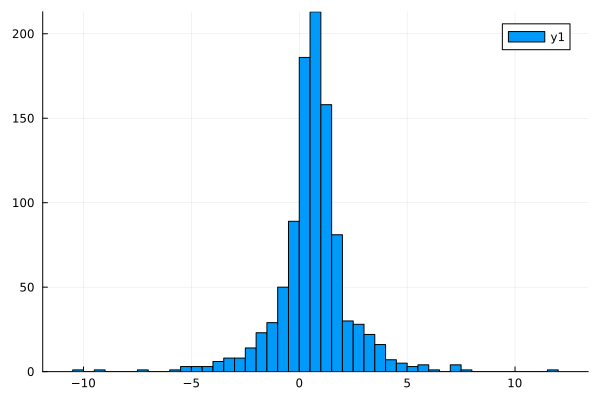

In [96]:
histogram(postDF[:, 5])